In [2]:
import sys, os
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath(".."))
from yahoo_data.services.get_ta_indicators import GenerateTechnicalIndicators
from yahoo_data.services.get_price_data import GetPriceData
from yahoo_data.services.get_pca import GeneratePCAByGrouping

# petr4_price_df = GetPriceData().get_price_data(
#     'PETR4.SA',
#     '2015-01-01',
#     '2020-01-01'
# )


In [3]:
technical_indicators_petr4_df = GenerateTechnicalIndicators(
    'PETR4.SA',
    '2015-01-01',
    '2020-01-01'
).run_with_default_params()

In [3]:
# print(technical_indicators_petr4_df['Date'])

In [4]:
technical_indicators_petr4_df = technical_indicators_petr4_df.dropna()

In [1]:
# print(technical_indicators_petr4_df)

In [5]:
from yahoo_data.services.get_pca import GeneratePCAByGrouping

groups = [
        {
            "group_name": 'trend_pca',
            "group_columns": ['sma', 'wma', 'cci']
        },
        {
            "group_name": "mean_reversion_pca",
            "group_columns": ['fast_stoch', 'fast_signal', 'slow_stoch', 'slow_signal']
        },
        {
            "group_name": "relative_strength_pca",
            "group_columns": ['rsi', 'williams_r']
        },
        {
            "group_name": "volume_pca",
            "group_columns": ["on_balance", "MFI"]
        },
        {
            "group_name": "momentum_pca",
            "group_columns": ["macd", "roc", "roc_perc", "momentum" , "chande"]
        }
    ]

petr4_after_pca = GeneratePCAByGrouping().generate_pca(
    df = technical_indicators_petr4_df, 
    groupings = groups,
    columns_to_leave = ['Open', 'High', 'Low', 'Close'],
)


In [6]:
print(petr4_after_pca.columns)

Index(['trend_pca', 'mean_reversion_pca', 'relative_strength_pca',
       'volume_pca', 'momentum_pca', 'Open', 'High', 'Low', 'Close'],
      dtype='object')


In [7]:
from portfolio_management.services.get_stock_pnl import StockPnLCalculator

petr4_1_days = StockPnLCalculator().calculate_pnl(
    petr4_after_pca,
    'Close',
    1
    )

petr4_3_days = StockPnLCalculator().calculate_pnl(
    petr4_after_pca,
    'Close',
    3
)
petr4_5_days = StockPnLCalculator().calculate_pnl(
    petr4_after_pca,
    'Close',
    5
)
petr4_30_days = StockPnLCalculator().calculate_pnl(
    petr4_after_pca,
    'Close',
    30
)
columns_to_drop = ['Open', 'High', 'Low', 'Close']
petr4_1_days=petr4_1_days.drop(columns = columns_to_drop).dropna()
petr4_3_days=petr4_3_days.drop(columns = columns_to_drop).dropna()
petr4_5_days=petr4_5_days.drop(columns = columns_to_drop).dropna()
petr4_30_days=petr4_30_days.drop(columns = columns_to_drop).dropna()
print(petr4_1_days)

                            trend_pca  mean_reversion_pca  \
Date                                                        
2015-02-13 00:00:00-02:00  -72.020080           -1.362036   
2015-02-18 00:00:00-02:00  -97.854266          -17.691510   
2015-02-19 00:00:00-02:00  -38.077589          -19.228627   
2015-02-20 00:00:00-02:00  -18.841103          -14.652619   
2015-02-23 00:00:00-03:00   24.715080           -3.134398   
...                               ...                 ...   
2019-12-20 00:00:00-03:00  -15.258828          -30.203693   
2019-12-23 00:00:00-03:00  -16.330239          -34.312594   
2019-12-26 00:00:00-03:00 -123.692913          -49.151300   
2019-12-27 00:00:00-03:00 -143.343221          -48.114534   
2019-12-30 00:00:00-03:00  -66.244350          -36.181748   

                           relative_strength_pca    volume_pca  momentum_pca  \
Date                                                                           
2015-02-13 00:00:00-02:00             -95.1773

ANALYSIS FOR 1 DAY!

Mean Absolute Error: 0.02
Mean Absolute Error / Média 9.57

RMSE:  0.033
Média do resultado financeiro: 0.00247
RMSE/Média 13.33395


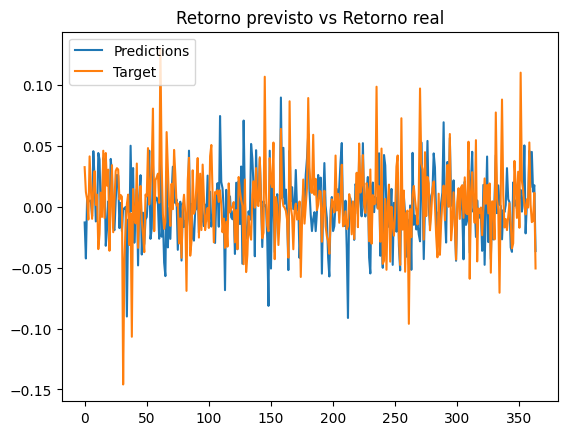

% Acerto de tendencia: 0.6401098901098901


In [8]:

import numpy as np
analysis_df = petr4_1_days.copy(deep = True)

target_df = analysis_df['Close PnL 1 days']
target_array = np.array(target_df)

features_df = analysis_df.drop(columns='Close PnL 1 days')
features_array = np.array(features_df)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math  

np.random.seed(31415) 

min_max_scaler = preprocessing.MinMaxScaler()

train_features, test_features, train_target, test_target = train_test_split(features_array, target_array, test_size = 0.3)
start_date = petr4_1_days.loc[petr4_1_days['Close PnL 1 days'] == test_target[0]]

train_features = min_max_scaler.fit_transform(train_features)
test_features = min_max_scaler.fit_transform(test_features)
random_forests_intance = RandomForestRegressor(random_state=0)
random_forests_intance.fit(train_features, train_target)
predictions = random_forests_intance.predict(test_features)
errors = abs(predictions - test_target)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

Mean Absolute Error: 0.03
Mean Absolute Error / Média 4.4

RMSE:  0.047
Média do resultado financeiro: 0.0076
RMSE/Média 6.18359


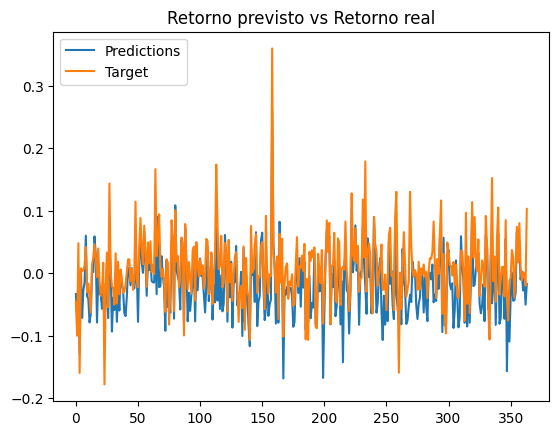

% Acerto de tendencia: 0.7445054945054945


In [9]:

import numpy as np
analysis_df = petr4_3_days.copy(deep = True)

target_df = analysis_df['Close PnL 3 days']
target_array = np.array(target_df)

features_df = analysis_df.drop(columns='Close PnL 3 days')
features_array = np.array(features_df)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math  

np.random.seed(31415) 

min_max_scaler = preprocessing.MinMaxScaler()

train_features, test_features, train_target, test_target = train_test_split(features_array, target_array, test_size = 0.3)
start_date = petr4_3_days.loc[petr4_3_days['Close PnL 3 days'] == test_target[0]]

train_features = min_max_scaler.fit_transform(train_features)
test_features = min_max_scaler.fit_transform(test_features)
random_forests_intance = RandomForestRegressor(random_state=0)
random_forests_intance.fit(train_features, train_target)
predictions = random_forests_intance.predict(test_features)
errors = abs(predictions - test_target)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

Mean Absolute Error: 0.03
Mean Absolute Error / Média 3.8

RMSE:  0.048
Média do resultado financeiro: 0.00872
RMSE/Média 5.50717


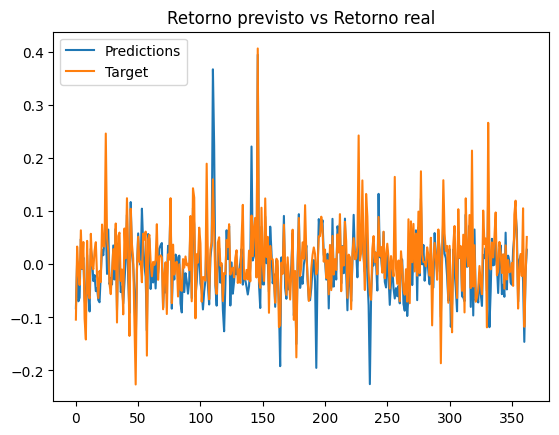

% Acerto de tendencia: 0.8071625344352618


In [10]:

import numpy as np
analysis_df = petr4_5_days.copy(deep = True)

target_df = analysis_df['Close PnL 5 days']
target_array = np.array(target_df)

features_df = analysis_df.drop(columns='Close PnL 5 days')
features_array = np.array(features_df)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math  

np.random.seed(31415) 

min_max_scaler = preprocessing.MinMaxScaler()

train_features, test_features, train_target, test_target = train_test_split(features_array, target_array, test_size = 0.3)
start_date = petr4_5_days.loc[petr4_5_days['Close PnL 5 days'] == test_target[0]]

train_features = min_max_scaler.fit_transform(train_features)
test_features = min_max_scaler.fit_transform(test_features)
random_forests_intance = RandomForestRegressor(random_state=0)
random_forests_intance.fit(train_features, train_target)
predictions = random_forests_intance.predict(test_features)
errors = abs(predictions - test_target)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()

direction_count = 0
for index in range(len(predictions)):
    if predictions[index] > 0 and test_target[index] > 0:
        direction_count += 1
    if predictions[index] < 0 and test_target[index] < 0:
        direction_count += 1

print(f'% Acerto de tendencia: {direction_count/len(predictions)}')

In [ ]:

import numpy as np
analysis_df = petr4_3_days.copy(deep = True)

target_df = analysis_df['Close PnL 30 days']
target_array = np.array(target_df)

features_df = analysis_df.drop(columns='Close PnL 1 days')
features_array = np.array(features_df)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math  

np.random.seed(31415) 

min_max_scaler = preprocessing.MinMaxScaler()

train_features, test_features, train_target, test_target = train_test_split(features_array, target_array, test_size = 0.3)
start_date = petr4_1_days.loc[petr4_1_days['Close PnL 1 days'] == test_target[0]]

train_features = min_max_scaler.fit_transform(train_features)
test_features = min_max_scaler.fit_transform(test_features)
random_forests_intance = RandomForestRegressor(random_state=0)
random_forests_intance.fit(train_features, train_target)
predictions = random_forests_intance.predict(test_features)
errors = abs(predictions - test_target)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Mean Absolute Error / Média', round(np.mean(errors)/np.mean(test_target), 2))
# Predicting the target values of the test set

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(test_target, predictions)), '.3f'))
print("\nRMSE: ", rmse)

print("Média do resultado financeiro:", round(np.mean(test_target), 5))
print("RMSE/Média", round(rmse/np.mean(test_target), 5))


plt.plot(predictions, label='Predictions')
plt.plot(test_target, label='Target')
plt.legend(loc="upper left")
plt.title('Retorno previsto vs Retorno real')
plt.show()